In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
from Algorithms.HelicopterTriggerIndex import *
import seaborn as sns
sns.set(font_scale=2)
import cartopy.crs as ccrs
import pandas as pd
import shapely.geometry as sgeom

def f_2_m(f,R=0):
    # Meter til Fot
    if R:
        return 3.2808399*f

    # Fot til Meter
    else:
        return 0.3048*f
projection = ccrs.LambertConformal(central_latitude=63,central_longitude=15,standard_parallels=[63,63],cutoff=-30)
outsource = "../Thesis_source/MasterThesis/Figures/"

ext_folder = "source_disk/MEPS/extracted_variables/"
sub_folder = "source_disk/MEPS/subset_variables/"
hti_folder = "source_disk/MEPS/forecasted_HTI_MEPS/"
analysis = pd.read_csv("source/analysis_dataset_new.csv")
cases = pd.read_csv("source/dataset_new.csv")
height_cases = pd.read_csv("source/dataset_H.csv")

In [2]:
new_cases = []
for DS in [analysis,cases]:
    for i,row in DS.iterrows():
        year = int(str(row[0])[:4])
        month = int(str(row[0])[4:6])
        
        if year < 2016:
            continue
        if year == 2016 and month < 12:
            continue
        new_cases.append(row)
new_cases = pd.DataFrame(new_cases)

In [3]:
for i, row in new_cases.iterrows():
    if row[1] == 0:
        print(row)

In [4]:
for i , row in new_cases.iterrows():
    print(row)
    break

date      20171123
time            17
place1        ENXA
place2        ENZV
height        3000
temp             1
type             H
lat            NaN
lon            NaN
Name: 9, dtype: object


In [5]:
def fetchfields(xarray):
    geo_pl = xarray["geopotential_pl"]
    geo_sf = xarray["surface_geopotential"]
    airtemp_pl = xarray["air_temperature_pl"]
    upward_pl = xarray["upward_air_velocity_pl"]

    lowcloud = xarray["low_type_cloud_area_fraction"]
    prec = xarray["precipitation_amount_acc"]

    return  geo_pl, geo_sf, airtemp_pl, upward_pl, lowcloud, prec

def fetchfields_sub(xarray):
    geo_pl = xarray["geopotential_pl"]
    geo_sf = xarray["surface_geopotential"]
    airtemp_pl = xarray["air_temperature_pl"]

    lowcloud = xarray["low_type_cloud_area_fraction"]
    prec = xarray["precipitation_amount_acc"]

    return  geo_pl, geo_sf, airtemp_pl, lowcloud, prec

def get_height_value_from_pl(geopotential_pl,variable_pl,height=750):
    # Assume 925 to 850 band always has interesting heights. May need changing later
    # Also Assume 9.81 is correct gravitational constant ( should be to 1%)
    z2,z1 = geopotential_pl.sel(pressure=850)/9.81 , geopotential_pl.sel(pressure=925)/9.81
    v2,v1 = variable_pl.sel(pressure=850) , variable_pl.sel(pressure=925)
    variableperheight = (v2-v1)/(z2-z1)
    result = v1 + variableperheight*(height - z1)
    return result

folder = "source_disk/MEPS/extracted_variables/"
htiseason = []
for file in sorted(os.listdir(folder))[1:]:
    month = int(file[14:16])
    if month < 5 or month > 9:
        htiseason.append(file)
        
day = htiseason[0]

xarray  = xr.open_dataset(folder+day).isel(ensemble_member=0,height0=0)
geo_pl, geo_sf, airtemp_pl,  upward_pl, lowcloud, prec = fetchfields(xarray)
geo_sf = geo_sf.isel(time=range(1,7))

Nbh = 7
topomin = np.zeros_like(geo_sf)
topomax = np.zeros_like(topomin)
for time in range(len(geo_sf["time"])):
    topomax[time] = neighbourhood_max(geo_sf.isel(time=time).values,Nbh)
    topomin[time] = neighbourhood_min(geo_sf.isel(time=time).values,Nbh)

In [6]:
@numba.jit
def neighbourhood_max(xarrayvalues,neigbhoursize = 3):
    N = neigbhoursize
    # Assume incoming object to be numpy array
    X,Y = xarrayvalues.shape
    result = np.zeros((X,Y))
    # First fill non-trivial parts
    for y in range(N,Y-N + 1+1):
        for x in range(N,X-N + 1+1):
            result[x,y] = np.max(xarrayvalues[x-N:x+N + 1,y-N:y+N + 1])
    for i in range(N):
        for y in range(Y):
            result[i,y] = xarrayvalues[i,y]
            result[-(1+i),y] = xarrayvalues[-(1+i),y]
        for x in range(X):
            result[x,i] = xarrayvalues[x,i]
            result[x,-(1+i)] = xarrayvalues[x,-(1+i)]
    return result

@numba.jit
def neighbourhood_min(xarrayvalues,neigbhoursize = 3):
    N = neigbhoursize
    # Assume incoming object to be numpy array
    X,Y = xarrayvalues.shape
    result = np.zeros((X,Y))
    # First fill non-trivial parts
    for y in range(N,Y-N + 1+1):
        for x in range(N,X-N + 1+1):
            result[x,y] = np.min(xarrayvalues[x-N:x+N + 1,y-N:y+N + 1])
    for i in range(N):
        for y in range(Y):
            result[i,y] = xarrayvalues[i,y]
            result[-(1+i),y] = xarrayvalues[-(1+i),y]
        for x in range(X):
            result[x,i] = xarrayvalues[x,i]
            result[x,-(1+i)] = xarrayvalues[x,-(1+i)]
    return result

def temperature_max_band_from_b_to_c(b,c):
    """
    NOTE: C < B
    Gives high risk (1 or 100%) for temperatures in [c,b] gives [0,1] for [a,b]
    and [1,0] for [c,d] (linear mapping)
    """
    # Define a and d for linear mapping
    a = b + 1
    d = c - 1
    def f(T):
        a_slice = np.where(T > -1,1,0)
        a_slice[np.where(T > 0)] = 0
        b_slice = np.where(T < -1,1,0)
        c_slice = np.where(T > -6,1,0)

        d_slice = np.where(T > -7,1,0)
        d_slice[np.where(T > -6)] = 0

        new_slice = np.where(b_slice == c_slice,1.0,0.0)
        new_slice[np.where(a_slice)] = abs(abs(T[np.where(a_slice)] -abs(a)))
        new_slice[np.where(d_slice)] =  abs(abs(T[np.where(d_slice)])  - abs(d))
        return new_slice
    return f

tfunc = temperature_max_band_from_b_to_c(-1,-6)

def only_positive_but_no_larger_than_1(array):
    size = array.shape
    result = np.zeros(size)
    result[np.where(array > 0)] = np.minimum(1.5*array[np.where(array>0)],1)
    return result

def only_positive_but_no_larger_than_1_with_scaling(topoarray,scaling = 15000):
    def f(array):
        size = array.shape
        result = np.zeros(size)
        result[np.where(array > 0) and np.where(topoarray < 10)] = np.minimum(1.5*array[np.where(array>0) and np.where(topoarray < 10)],1)
        scalingfactor = 1-(topoarray[np.where(array>0) and np.where(topoarray>10)]/scaling)
        result[np.where(array > 0) and np.where(topoarray > 10)] = np.minimum(scalingfactor*1.5*array[np.where(array > 0) and np.where(topoarray > 10)],1)
        result[np.where(result < 0)] = 0
        return result
    return f

wfunc = only_positive_but_no_larger_than_1_with_scaling(topomax)
pfunc = only_positive_but_no_larger_than_1
cfunc = lambda x: x

def mask(array,topmax=topomax,topmin=topomin):
    array[np.where(topmax >= 7500)] = 0
    array[np.where(topmin >= 10)] = 0
    return array


In [8]:
def plot_HTI(da,ax):
    da.plot.pcolormesh(levels=[0,0.00000001,0.7,0.90,0.99,1],vmax=1,ax=ax,transform=projection,
              colors=["#a3b8c7","#ffffff", "#fcbd00", "#fc5600", "#fc0000"],
              cbar_kwargs = {
                  "ticks" : [0.000001,0.7,0.9,0.99,1],"label" : "Helicopter Trigger Index - HTI","shrink":0.7,"pad":0.002}
             );
    return ax
projection = ccrs.LambertConformal(central_latitude=63,central_longitude=15,standard_parallels=[63,63],cutoff=-30)


def mask(array,topmax=topomax,topmin=topomin):
    array[np.where(topmax >= 7500)] =  array[np.where(topmax >= 7500)]
    array[np.where(topmin >= 10)] = array[np.where(topmin >= 10)]
    return array

def only_positive_but_no_larger_than_1_with_scaling(topoarray,scaling = 15000):
    def f(array):
        size = array.shape
        result = np.zeros(size)
        result[np.where(array > 0) and np.where(topoarray < 10)] = np.minimum(1.5*array[np.where(array>0) and np.where(topoarray < 10)],1)
        scalingfactor = 1-(topoarray[np.where(array>0) and np.where(topoarray>10)]/scaling)
        result[np.where(array > 0) and np.where(topoarray > 10)] = np.minimum(scalingfactor*1.5*array[np.where(array > 0) and np.where(topoarray > 10)],1)
        result[np.where(result < 0)] = 0
        return result
    return f

dict_loc = {}

N=0
values_list = []
print("C,T,P,Pf,HTI,H")
for nr, row in new_cases.iterrows():
    if not row[-3] == "H":
        continue
    if not abs(row[-1]) > 0:
        continue
        
    lat,lon = row[-2:]
    HTI = 0
    year = int(str(row[0])[:4])
    month = int(str(row[0])[4:6])
    
    if row[1] in [3,4,5,6,7,8]:
        term = 0
    elif row[1] in [9,10,11,12,13,14]:
        term = 6
    elif row[1] in [15,16,17,18,19,20]:
        term = 12
    elif row[1] in [21,22,23]:
        term = 18
    else: 
        print(nr,row)
        continue
    time_index = row[1] - (term+3)  
    try: 
        MEPS = xr.open_dataset(ext_folder+"extracted_%iT%2.2iZ.nc"%(row[0],term)).isel(ensemble_member=0,height0=0)
        geo_pl, geo_sf, airtemp_pl,  upward_pl, lowcloud, prec = fetchfields(MEPS)
    except:
        try:
            MEPS = xr.open_dataset(sub_folder+"subset_%iT%2.2iZ.nc"%(row[0],term)).isel(ensemble_member=0,height0=0)
            geo_pl, geo_sf, airtemp_pl, lowcloud, prec = fetchfields_sub(MEPS)
        except:
            continue
    X = MEPS.dims["x"]
    Y = MEPS.dims["y"]
    new_ds = xr.Dataset(  {
        "T": (("y", "x"), np.zeros((Y,X))),
        "C": (("y", "x"), np.zeros((Y,X))),
        "P": (("y", "x"),  np.zeros((Y,X))),
        "Pf": (("y", "x"), np.zeros((Y,X))),
               },
         coords={'x': MEPS.x,'y': MEPS.y}) 

    Nbh = 7
    geo_sf = geo_sf.isel(time=0)
    topomin = np.zeros_like(geo_sf)
    topomax = np.zeros_like(topomin)
    topomax = neighbourhood_max(geo_sf.values,Nbh)
    topomin = neighbourhood_min(geo_sf.values,Nbh)
    wfunc = only_positive_but_no_larger_than_1_with_scaling(topomax)
    pfunc = only_positive_but_no_larger_than_1
    cfunc = lambda x: x

    prec0 = prec.isel(time = time_index)
    prec = (prec- prec.shift({"time":1},fill_value=0)).isel(time = time_index)
    prec = prec.where(prec >0,0)
    air_temp = get_height_value_from_pl(geo_pl,airtemp_pl-273.15).isel(time = time_index)
    lowcloud = lowcloud.isel(time = time_index)

    cl = np.zeros_like(lowcloud)
    pc = np.zeros_like(prec0)
    pc_fix = np.zeros_like(prec)
    
    cl = neighbourhood_max(lowcloud.values,Nbh)
    cl-= neighbourhood_min(lowcloud.values,Nbh)
    pc = neighbourhood_max(prec0.values,Nbh)
    pc_fix = neighbourhood_max(prec.values,Nbh)
    
    index = True
    if index:
        Cpart = cfunc(cl)
        Tpart = tfunc(air_temp.values)
        Ppart = pfunc(pc)
        Pfpart= pfunc(pc_fix)
    else:
        Cpart = cl
        Tpart = air_temp.values
        Ppart = pc
        Pfpart= pc_fix
    new_ds["C"] += Cpart/4
    new_ds["T"] += Tpart/4
    new_ds["P"] += Ppart/4
    new_ds["Pf"]+= Pfpart/4

    point = sgeom.Point(lon,lat)
    Point = projection.project_geometry(point)
    point_ds = new_ds.sel(x=Point.x, y=Point.y,method="nearest")
    TIME = lowcloud.time.values
    values = []
    for var in ["C","T","P","Pf"]:
        values.append(float(point_ds[var].values))
    
    HTI = xr.open_dataset(hti_folder+"HTI_%iT%2.2iZ.nc"%(row[0],term)).helicopter_triggered_index.sel(x=Point.x,y=Point.y,time=TIME,method="nearest").values
    values.append(float(HTI))
    values.append(row[4])
    print(row[0],row[1],values)
    values_list.append(values)

"""
    fig,axs = plt.subplots(ncols=2,nrows=3, subplot_kw={'projection': projection},figsize = (6,9))

    (new_ds["W"]+new_ds["C"]+new_ds["T"]+new_ds["Pf"]).plot(ax=axs[0][0])
    new_ds["W"].plot(ax=axs[0][1],cbar_kwargs = {"pad":0.002,"label" : ""})
    new_ds["C"].plot(ax=axs[1][0],cbar_kwargs = {"pad":0.002,"label" : ""})
    new_ds["T"].plot(ax=axs[1][1],cbar_kwargs = {"pad":0.002,"label" : ""})
    new_ds["P"].plot(ax=axs[2][0],cbar_kwargs = {"pad":0.002,"label" : ""})
    new_ds["Pf"].plot(ax=axs[2][1],cbar_kwargs = {"pad":0.002,"label" : ""})

    axs[0][0].set_title("Total HTI")
    axs[0][1].set_title("Vertical Velocity")
    axs[1][0].set_title("Cloud cover")
    axs[1][1].set_title("Temperature")
    axs[2][0].set_title("Precipitation")
    axs[2][1].set_title("Fixed Precipitation")
    place1,place2 = row[2:4]

    fig.suptitle("%s flying from %s (to %s)"%({"H":"Helicopter","FW":"Fixed Wing"}[row[-1]],place1,place2),va="bottom",y=0.92)
    #fig.savefig(outsource+"Decomp%2.2i.png"%N, bbox_inches = 'tight', pad_inches = 0.01)
    N+=1
    plt.show()
""";

C,T,P,Pf,HTI,H
20161230 12 [0.01491546630859375, 0.25, 0.25, 0.25, 0.0, 5500.0]
20170111 17 [0.24541473388671875, 0.25, 0.25, 0.24342012405395508, 0.9359314441680908, 2000.0]
20170112 20 [0.24916839599609375, 0.25, 0.25, 0.00803518295288086, 0.8976495862007141, 5000.0]
20171127 17 [0.19039154052734375, 0.1695949596791238, 0.25, 0.25, 0.7836004495620728, 500.0]
20180101 12 [0.24991607666015625, 0.25, 0.0009348392486572266, 0.0008182525634765625, 0.5306686758995056, 500.0]
20180117 18 [0.13687896728515625, 0.25, 0.25, 0.011928319931030273, 0.7276027202606201, 500.0]
20180212 18 [0.25, 0.25, 0.25, 0.003769397735595703, 0.8414369225502014, 2000.0]
20180213 9 [0.249847412109375, 0.25, 0.1622765064239502, 0.1622765064239502, 0.8278956413269043, 2000.0]
20180215 12 [0.15828704833984375, 0.25, 0.25, 0.25, 0.9082870483398438, 2000.0]
20180215 13 [0.09261322021484375, 0.25, 0.25, 0.25, 0.830631673336029, 2000.0]
20180215 14 [0.0830535888671875, 0.25, 0.25, 0.25, 0.8330535888671875, 2000.0]
20180

In [110]:
Clist = np.zeros(len(values_list))
Tlist = np.zeros(len(values_list))
Pflist = np.zeros(len(values_list))
Plist = np.zeros(len(values_list))
Hlist = np.zeros(len(values_list))
for i,values in enumerate(values_list):
    C,T,P,Pf,HTI,H = values
    Clist[i] = C*4
    Tlist[i] = T*4
    Pflist[i] = Pf*4
    Plist[i] = P*4
    Hlist[i] = HTI

In [111]:
for C,T,P,I in zip(Clist,Tlist,Pflist,Hlist):
    print(T,P,I)

-3.0823581098519774 3.819507598876953 0.0
-1.0797543958738824 0.6491203308105469 0.9359314441680908
-2.1092296490582583 0.021427154541015625 0.8976495862007141
-0.6783798387164952 1.2780704498291016 0.7836004495620728
-4.165318403280763 0.0021820068359375 0.5306686758995056
-1.8115457320022907 0.03180885314941406 0.7276027202606201
-2.8369787362410683 0.010051727294921875 0.8414369225502014
-3.4957593250379944 0.4327373504638672 0.8278956413269043
-2.621429892473257 4.037544250488281 0.9082870483398438
-1.9257441147868688 2.3286819458007812 0.830631673336029
-1.9784854455130594 8.993629455566406 0.8330535888671875
-4.254178473490293 2.173769950866699 0.7574691772460938


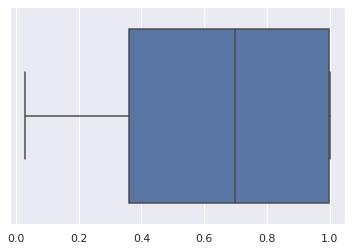

In [84]:
sns.boxplot(Clist);

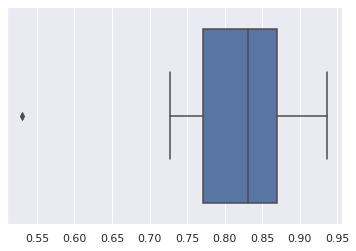

In [87]:
sns.boxplot(Hlist[1:])

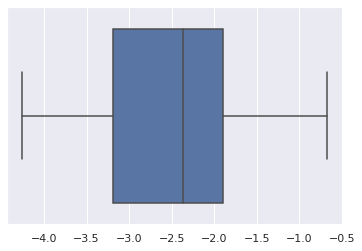

In [85]:
sns.boxplot(Tlist)

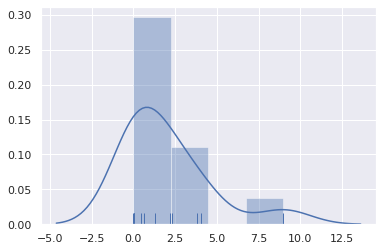

In [82]:
sns.distplot(Pflist,rug=1)

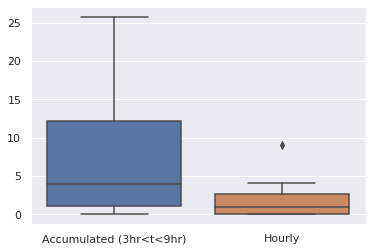

In [83]:
sns.boxplot(data = [Plist,Pflist]);
plt.xticks([0,1],["Accumulated (3hr<t<9hr)","Hourly"]);

11


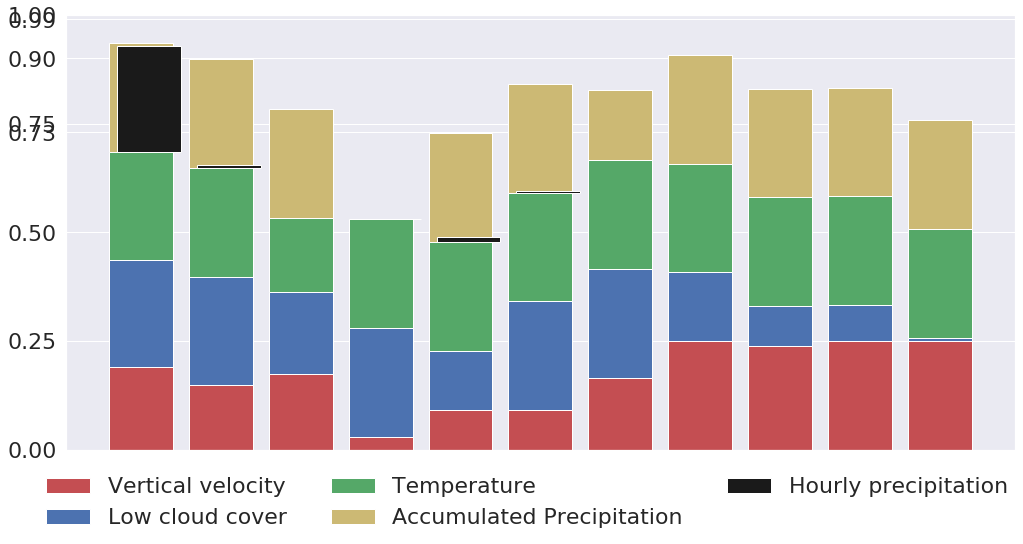

In [31]:
plt.figure(figsize=(17,8))
xlabls = []
colors = ["r","b","g","y","k"]
legend = ["Vertical velocity","Low cloud cover","Temperature","Accumulated Precipitation","Hourly precipitation"]
S = 0
for x,l in enumerate(values_list):
    W = l[4]

    for item in l[:3]:
        W-= item
    if abs(l[4]) < 1e-13:
        W = 0
        S +=1
        continue
        xlabls.append(str(l[-1])+"*")
    else:
        xlabls.append(str(l[-1]))
    if W < 0:
        W = 0
    
    last = 0
    #print(x,[W,l[0],l[1],l[2]],l[3],l[4])
    
    for i,item in enumerate([W,l[0],l[1],l[2]]):
        plt.bar(x-S,item,color=colors[i],bottom = last)
        last += item

    if l[2] > l[3]:
        last = 0
        for i,item in enumerate([W,l[0],l[1],l[2],l[3]]):
            if x == 2:
                if i!= 4:
                    plt.bar(x-S,item,color=colors[i],label=legend[i],bottom = last)
                if i == 4:
                    plt.bar(x-S+.1,item,color=colors[i],label=legend[i],bottom=last)
                if i != 3:
                    last += item
                continue
            if i == 3:
                continue
            elif i == 4:
                plt.bar(x-S+.1,item,color=colors[i],bottom = last )
            else:
                plt.bar(x-S,item,color=colors[i],bottom = last)

            last += item

plt.legend(ncol=3,loc = [-0.03,-0.2],framealpha=0)
print(len(values_list)-S)
plt.xticks(range(0),xlabls,rotation=90);
plt.yticks([0,0.25,0.5,0.73,0.75,.9,0.99,1]);
plt.savefig(outsource+"HeliDecomp.pdf",bbox_inches = 'tight', pad_inches = 0.01)

34


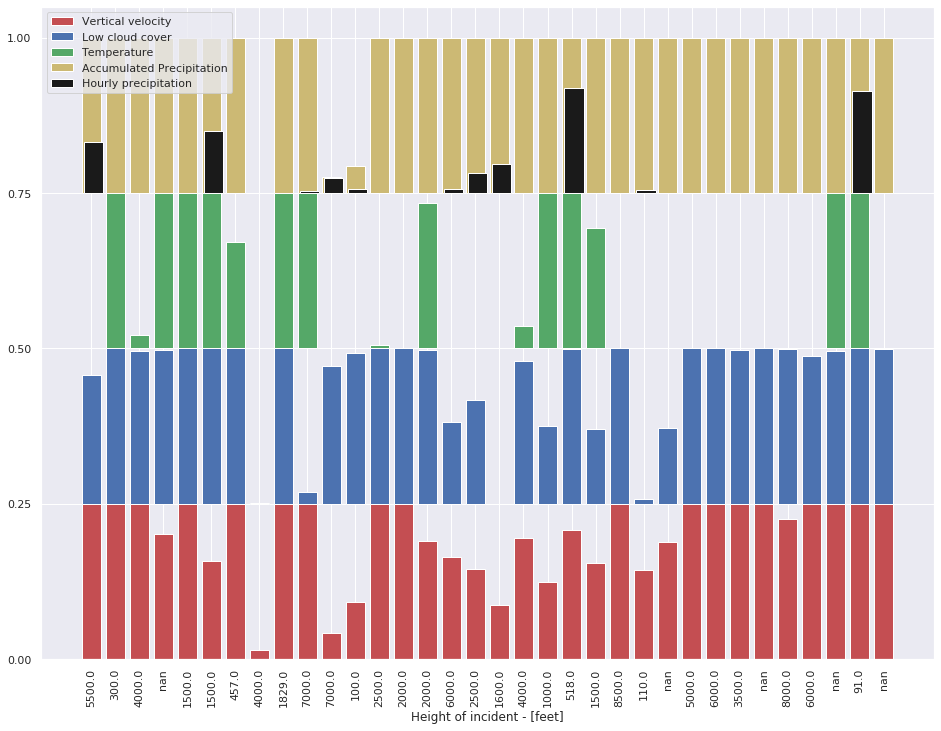

In [16]:
plt.figure(figsize=(16,12))
xlabls = []
colors = ["r","b","g","y","k"]
legend = ["Vertical velocity","Low cloud cover","Temperature","Accumulated Precipitation","Hourly precipitation"]
S = 0
for x,l in enumerate(values_list):
    W = l[4]

    for item in l[:3]:
        W-= item
    if abs(l[4]) < 1e-13:
        W = 0
        S +=1
        continue
        xlabls.append(str(l[-1])+"*")
    else:
        xlabls.append(str(l[-1]))
    if W < 0:
        W = 0
    
    last = 0
    #print(x,[W,l[0],l[1],l[2]],l[3],l[4])
    
    for i,item in enumerate([W,l[0],l[1],l[2]]):
        plt.bar(x-S,item,color=colors[i],bottom = last)
        last += .25
    if l[2] > l[3]:
        last = 0
        for i,item in enumerate([W,l[0],l[1],l[2],l[3]]):
            if x == 2:
                if i!= 4:
                    plt.bar(x-S,item,color=colors[i],label=legend[i],bottom = last)
                if i == 4:
                    plt.bar(x-S+.1,item,color=colors[i],label=legend[i],bottom=last)
                if i != 3:
                    last += .25
                continue
            if i == 3:
                continue
            elif i == 4:
                plt.bar(x-S+.1,item,color=colors[i],bottom = last)
            else:
                plt.bar(x-S,item,color=colors[i],bottom = last)

            last += .25

plt.legend(loc="upper left")
print(len(values_list)-S)
plt.xlabel("Height of incident - [feet]")
plt.xticks(range(len(values_list)-S),xlabls,rotation=90);
plt.yticks([0,0.25,0.5,0.75,1]);
plt.savefig(outsource+"FWDecomp.pdf",bbox_inches = 'tight', pad_inches = 0.01)

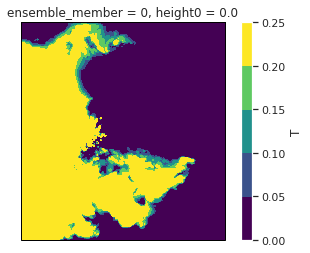

In [174]:
ax = plt.subplot(projection=projection)
new_ds.T.plot.contourf(ax=ax)

In [21]:
X = xarray.dims["x"]
Y = xarray.dims["y"]
new_ds = xr.Dataset(  {
        "T": (("y", "x"), np.zeros((Y,X))),
        "W": (("y", "x"), np.zeros((Y,X))),
        "C": (("y", "x"), np.zeros((Y,X))),
        "P": (("y", "x"),  np.zeros((Y,X))),
        "Pf": (("y", "x"), np.zeros((Y,X))),
               },
     coords={'x': xarray.x,'y': xarray.y},) 
N = 0

for day in htiseason:
    xarray  = xr.open_dataset(folder+day).isel(ensemble_member=0,height0=0)
    time = xarray.time[0].values.astype('datetime64[M]').astype(int)% 12 +1
    geo_pl, geo_sf, airtemp_pl,  upward_pl, lowcloud, prec = fetchfields(xarray)
    
    prec0 = prec.isel(time = range(1,7))
    prec = (prec- prec.shift({"time":1},fill_value=0)).isel(time = range(1,7))
    prec = prec.where(prec >0,0)
    air_temp = get_height_value_from_pl(geo_pl,airtemp_pl-273.15).isel(time=range(1,7))
    W_ = get_height_value_from_pl(geo_pl,upward_pl).isel(time=range(1,7))
    lowcloud = lowcloud.isel(time=range(1,7))
    
    
    Nbh = 7
    W = np.zeros_like(W_)
    cl = np.zeros_like(lowcloud)
    pc = np.zeros_like(prec0)
    pc_fix = np.zeros_like(prec)
    for time in range(len(W_["time"])):
        W[time] = neighbourhood_max(W_.isel(time=time).values,Nbh)
        cl[time] = neighbourhood_max(lowcloud.isel(time=time).values,Nbh)
        cl[time] -= neighbourhood_min(lowcloud.isel(time=time).values,Nbh)
        pc[time] = neighbourhood_max(prec0.isel(time=time).values,Nbh)
        pc_fix[time] = neighbourhood_max(prec.isel(time=time).values,Nbh)
    
    Wpart = np.mean(mask(wfunc(W)),axis=0)
    Cpart = np.mean(mask(cfunc(cl)),axis=0)
    if np.isnan(np.sum(Wpart)) or np.isnan(np.sum(Cpart)):
        print(day)
        continue
        
    new_ds["W"] += Wpart
    new_ds["C"] += Cpart

    new_ds["T"] += np.mean(mask(tfunc(air_temp.values)),axis=0)
    new_ds["P"] += np.mean(mask(pfunc(pc)),axis=0)
    new_ds["Pf"]+= np.mean(mask(pfunc(pc_fix)),axis=0)
    
    N+= 1
new_ds=new_ds/N
new_ds.to_netcdf("source_disk/results/part_climatology_mean.nc")

/home/johannestl/anaconda3/envs/Master/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater
/home/johannestl/anaconda3/envs/Master/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in greater
/home/johannestl/anaconda3/envs/Master/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in greater
/home/johannestl/anaconda3/envs/Master/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in less


extracted_20191014T00Z.nc


In [35]:
pc_fix[0] - new_ds["Pf"]

<xarray.DataArray 'Pf' (y: 949, x: 889)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.00184607, -0.00187765, -0.00190074, ..., -0.00286058,
        -0.00260347, -0.00257557],
       [-0.00188798, -0.0018795 , -0.00189903, ..., -0.00253539,
        -0.00256377, -0.00263496],
       [-0.00173796, -0.00183401, -0.00182682, ..., -0.0027623 ,
        -0.00253594, -0.0024583 ]])
Coordinates:
  * y                (y) float32 -1129330.6 -1126830.6 ... 1238169.4 1240669.4
  * x                (x) float32 -1022485.4 -1019985.4 ... 1195014.6 1197514.6
    ensemble_member  int16 ...
    height0          float32 ...

In [40]:
new_ds = xr.open_dataset("source_disk/results/part_climatology_mean.nc")
X = xarray.dims["x"]
Y = xarray.dims["y"]
new_ds1 = xr.Dataset(  {
        "T": (("y", "x"), np.zeros((Y,X))),
        "W": (("y", "x"), np.zeros((Y,X))),
        "C": (("y", "x"), np.zeros((Y,X))),
        "P": (("y", "x"),  np.zeros((Y,X))),
        "Pf": (("y", "x"), np.zeros((Y,X))),
               },
     coords={'x': xarray.x,'y': xarray.y},) 
N = 0

for day in htiseason:
    xarray  = xr.open_dataset(folder+day).isel(ensemble_member=0,height0=0)
    time = xarray.time[0].values.astype('datetime64[M]').astype(int)% 12 +1
    geo_pl, geo_sf, airtemp_pl,  upward_pl, lowcloud, prec = fetchfields(xarray)
    
    prec0 = prec.isel(time = range(1,7))
    prec = (prec- prec.shift({"time":1},fill_value=0)).isel(time = range(1,7))
    prec = prec.where(prec >0,0)
    air_temp = get_height_value_from_pl(geo_pl,airtemp_pl-273.15).isel(time=range(1,7))
    W_ = get_height_value_from_pl(geo_pl,upward_pl).isel(time=range(1,7))
    lowcloud = lowcloud.isel(time=range(1,7))
    
    Nbh = 7
    W = np.zeros_like(W_)
    cl = np.zeros_like(lowcloud)
    pc = np.zeros_like(prec0)
    pc_fix = np.zeros_like(prec)
    for time in range(len(W_["time"])):
        W[time] = neighbourhood_max(W_.isel(time=time).values,Nbh)
        cl[time] = neighbourhood_max(lowcloud.isel(time=time).values,Nbh)
        cl[time] -= neighbourhood_min(lowcloud.isel(time=time).values,Nbh)
        pc[time] = neighbourhood_max(prec0.isel(time=time).values,Nbh)
        pc_fix[time] = neighbourhood_max(prec.isel(time=time).values,Nbh)
    
    Wpart = mask(wfunc(W))
    Cpart = mask(cfunc(cl))
    Tpart = mask(tfunc(air_temp.values))
    Ppart = mask(pfunc(pc))
    Pfpart = mask(pfunc(pc_fix))
    if np.isnan(np.sum(Wpart)) or np.isnan(np.sum(Cpart)):
        print(day)
        continue
    
    for time in range(len(W_["time"])):
        new_ds1["W"] += (Wpart[time] - new_ds["W"])**2
        new_ds1["C"] += (Cpart[time] - new_ds["C"])**2
        new_ds1["T"] += (Tpart[time] - new_ds["T"])**2
        new_ds1["P"] += (Ppart[time] - new_ds["P"])**2
        new_ds1["Pf"]+= (Pfpart[time] - new_ds["Pf"])**2

    N+= len(W_["time"])

new_ds1=np.sqrt(new_ds1/N)
new_ds1.to_netcdf("source_disk/results/part_climatology_std.nc")
    

/home/johannestl/anaconda3/envs/Master/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater
/home/johannestl/anaconda3/envs/Master/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in greater
/home/johannestl/anaconda3/envs/Master/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in greater
/home/johannestl/anaconda3/envs/Master/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in less
/home/johannestl/anaconda3/envs/Master/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater
/home/johannestl/anaconda3/envs/Master/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater
/home/johannestl/anaconda3/envs/Master/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value enco

extracted_20191014T00Z.nc


Text(0.5, 1.0, '')

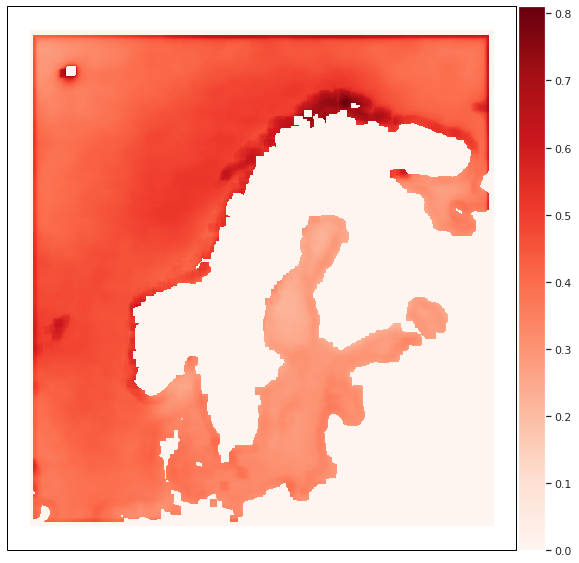

In [3]:
new_ds = xr.open_dataset("source_disk/results/part_climatology_mean.nc")
new_ds1 = xr.open_dataset("source_disk/results/part_climatology_std.nc")
projection = ccrs.LambertConformal(central_latitude=63,central_longitude=15,standard_parallels=[63,63],cutoff=-30)

fig = plt.figure(figsize = (12,10))
ax = plt.subplot(projection=projection)
new_ds["C"].plot(ax=ax,cmap="Reds",cbar_kwargs = {"label" : "","pad":0.002})
ax.set_title("")


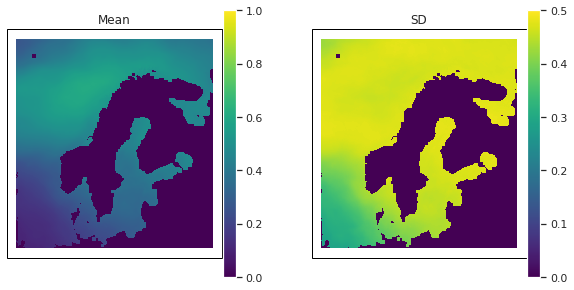

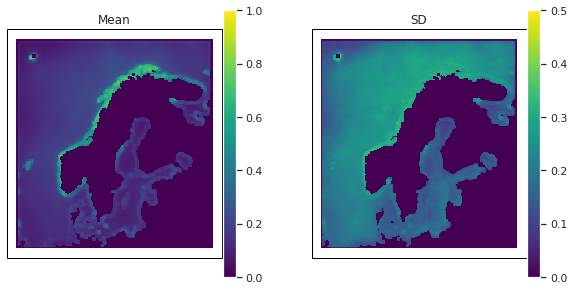

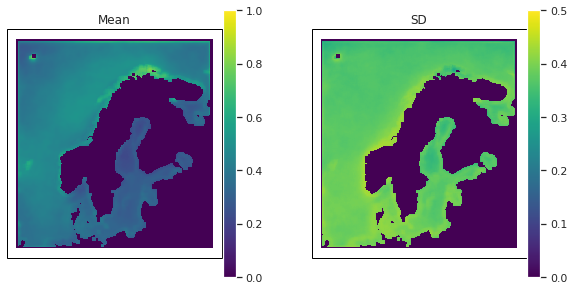

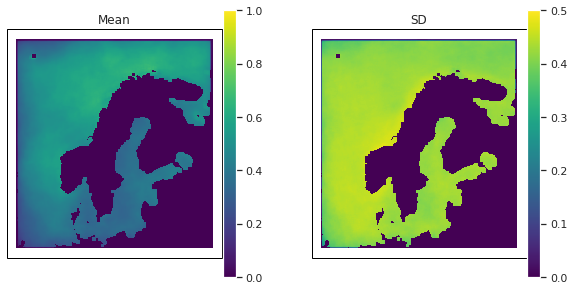

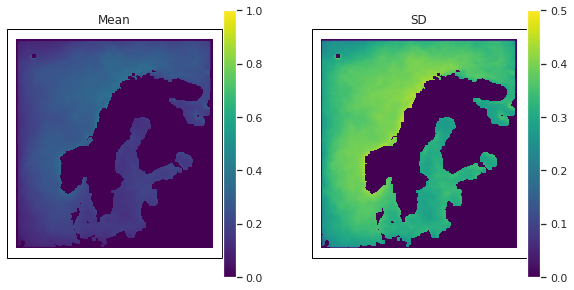

In [7]:
for key in new_ds:
    fig, (ax,ax1) = plt.subplots(ncols=2,subplot_kw={'projection': projection},figsize = (10,7))
    new_ds[key].plot(ax=ax,vmax=1,cbar_kwargs = {"shrink": 0.7,"label" : "","pad":0.002})
    new_ds1[key].plot(ax=ax1,vmax=.5,cbar_kwargs = {"shrink": 0.7,"label" : "","pad":0.002})
    ax.set_title("Mean")
    ax1.set_title("SD")
    fig.savefig(outsource+f"{key}.png",bbox_inches = 'tight', pad_inches = 0.01)
    plt.show()
    plt.close()

In [29]:
def get_height_value_from_pl(geopotential_pl,variable_pl,height=750):
    # Assume 925 to 850 band always has interesting heights. May need changing later
    # Also Assume 9.81 is correct gravitational constant ( should be to 1%)
    z2,z1 = geopotential_pl.sel(pressure=850)/9.81 , geopotential_pl.sel(pressure=925)/9.81
    v2,v1 = variable_pl.sel(pressure=850) , variable_pl.sel(pressure=925)
    variableperheight = (v2-v1)/(z2-z1)
    result = v1 + variableperheight*(height - z1)
    return result

def fetchfields(xarray):
    # Fetch fields used for operational HTI - post proccessing
    geo_pl = xarray["geopotential_pl"]
    geo_sf = xarray["surface_geopotential"]
    airtemp_pl = xarray["air_temperature_pl"]

    return  geo_pl, geo_sf, airtemp_pl
SUM = 0
N = 0
for day in htiseason:
    xarray  = xr.open_dataset(folder+day).isel(ensemble_member=0)
    geo_pl,geo_sf,airtemp_pl = fetchfields(xarray)
    T750 = get_height_value_from_pl(geo_pl,airtemp_pl) -273.15
    P =  T750.mean(dim="time")
    if np.sum(P).values != 0:
        SUM += T750.mean(dim="time")
        N+=1
SUM = (SUM/N)
(SUM).to_netcdf("source_disk/results/temperaturein750m.nc")

KeyboardInterrupt: 

In [56]:
SUM = xr.open_dataarray("source_disk/results/temperaturein750m.nc")
SUM

<xarray.DataArray (y: 949, x: 889)>
[843661 values with dtype=float64]
Coordinates:
    ensemble_member  int16 ...
    pressure         float32 ...
  * x                (x) float32 -1022485.4 -1019985.4 ... 1195014.6 1197514.6
  * y                (y) float32 -1129330.6 -1126830.6 ... 1238169.4 1240669.4
    longitude        (y, x) float64 ...
    latitude         (y, x) float64 ...

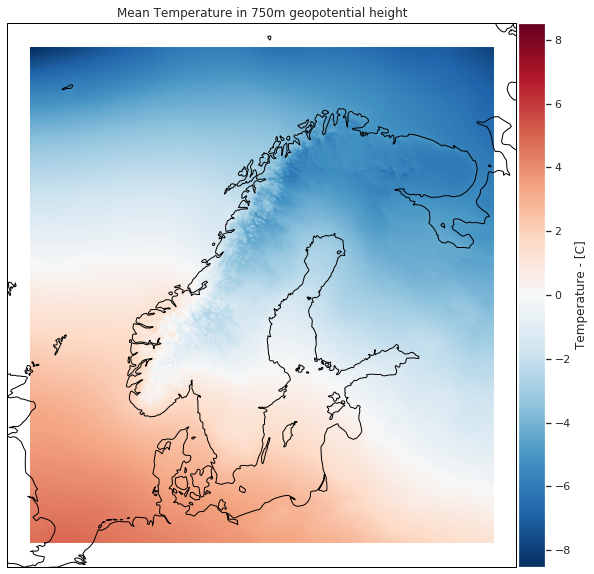

In [4]:
projection = ccrs.LambertConformal(central_latitude=63,central_longitude=15,standard_parallels=[63,63],cutoff=-30)

fig = plt.figure(figsize = (12,10))
ax = plt.subplot(projection=projection)
SUM.plot.pcolormesh(ax=ax,cbar_kwargs = {"label":"Temperature - [C]","pad":0.002})
ax.set_title("Mean Temperature in 750m geopotential height")
ax.coastlines("50m")
fig.savefig(outsource+"MeanT750MEPS.png", bbox_inches = 'tight', pad_inches = 0.01)

In [2]:
def f_2_m(f,R=0):
    # Meter til Fot
    if R:
        return 3.2808399*f

    # Fot til Meter
    else:
        return 0.3048*f
    
def estimate_pl(geopotential_pl,case_height):
    mean_height_pl = f_2_m(geopotential_pl.mean(axis=1).mean(axis=1)/9.81,1)
    dist = mean_height_pl - case_height
    return int(np.argmin(abs(dist)).values)

def get_height_value_from_pl(geopotential_pl,variable_pl,height=750,pmax=0,pmin=1):
    # pmax is index of levellist [975,950,925,900,875,850,825,800], if longer, geopotential is longer.
    # Also Assume 9.81 is correct gravitational constant ( should be to 1%)
    z2,z1 = geopotential_pl.isel(pressure=pmin)/9.81 , geopotential_pl.isel(pressure=pmax)/9.81
    v2,v1 = variable_pl.isel(pressure=pmin) , variable_pl.isel(pressure=pmax)
    variableperheight = (v2-v1)/(z2-z1)
    result = v1 + variableperheight*(height - z1)
    return result

def w_from_omega(omega,P,T,mix):
    eps = 0.622
    R_d = 287.058 
    T_v = T*((mix + eps)/(eps*(1+mix)))
    rho = P/ (R_d*T_v)
    return (-omega)/(rho*9.81)

analysis = pd.read_csv("source/analysis_dataset_new.csv")
cases = pd.read_csv("source/dataset_new.csv")
height_cases = pd.read_csv("source/dataset_H.csv")

In [4]:
analysis

,date,time,place1,place2,height,temp,type
0,20120422,20,ENUS,ENBN,3000.0,NaN,H
1,20121230,13,ENBN,NaN,NaN,0.0,H
2,20130208,19,ENSE,ENFL,3000.0,NaN,H
3,20130318,20,ENZV,Offshore,2000.0,NaN,H
4,20130503,7,ENBR,ENQA,2000.0,NaN,H
5,20131221,16,ENZV,Offshore,NaN,NaN,H
6,20141209,16,ENXA,ENZV,7000.0,-2.0,H
7,20151113,13,ENUC,ENKB,3000.0,NaN,H
8,20151127,13,ENUC,ENKB,3000.0,NaN,H
9,20171123,17,ENXA,ENZV,3000.0,1.0,H


In [9]:
def plot_HTI(da,ax):
    da.plot.pcolormesh(levels=[0,0.00000001,0.7,0.90,0.99,1],vmax=1,ax=ax,transform=projection,
              colors=["#a3b8c7","#ffffff", "#fcbd00", "#fc5600", "#fc0000"],
              cbar_kwargs = {
                  "ticks" : [0.000001,0.7,0.9,0.99,1],"label" : "Helicopter Trigger Index - HTI","shrink":0.7,"pad":0.002}
             );
    return ax
projection = ccrs.LambertConformal(central_latitude=63,central_longitude=15,standard_parallels=[63,63],cutoff=-30)


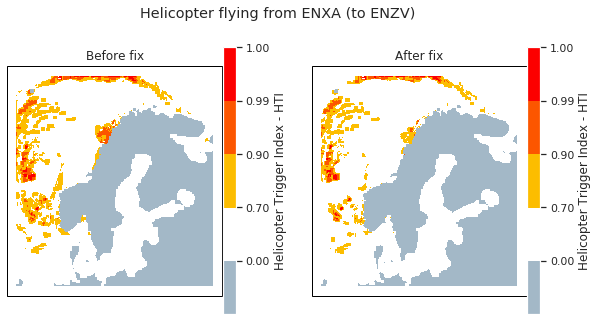

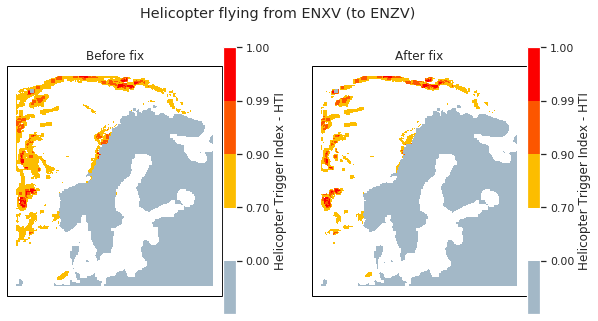

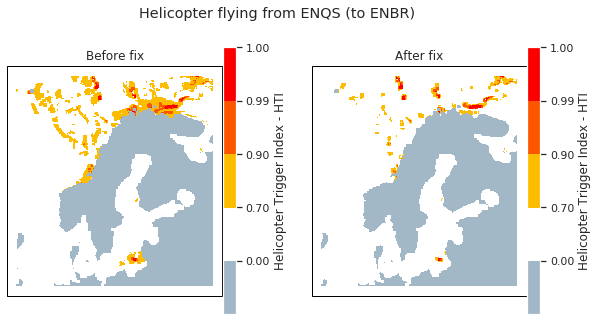

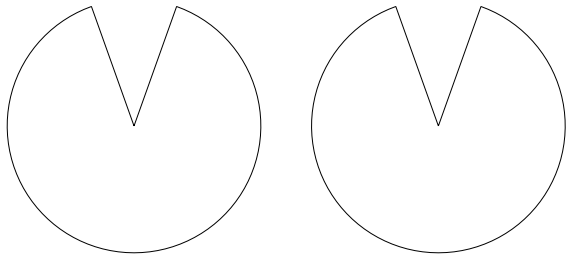

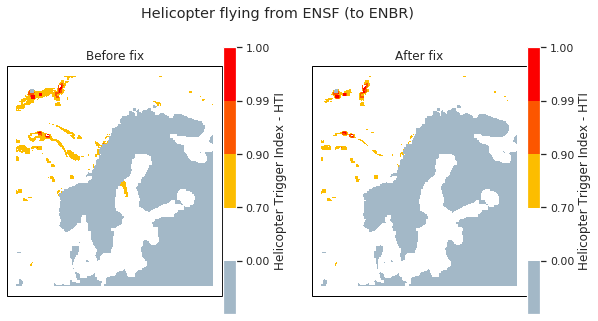

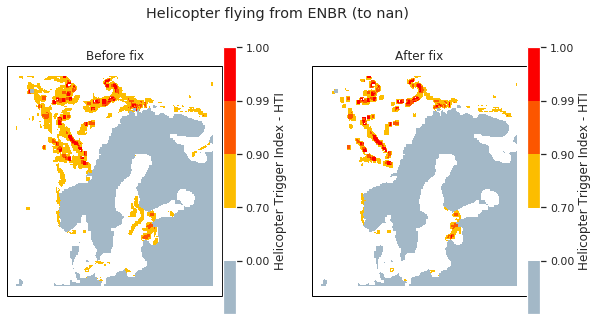

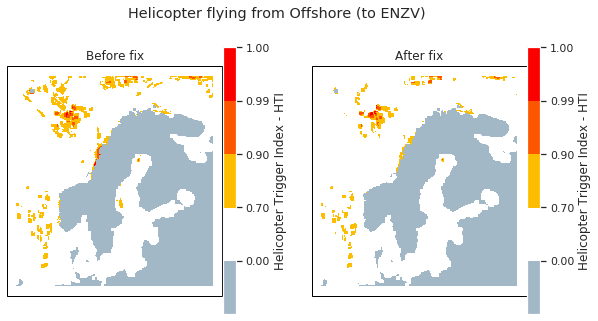

In [14]:
folder = "/home/johannestl/Desktop/Masteroppgaven/Master/source_disk/MEPS/forecasted_HTI_MEPS/" 
N = 0

for ds in [analysis]:
    for i, row in ds.iterrows():
        year = int(str(row[0])[:4])
        if year < 2017:
            continue
        height = row[-3]
        if not height > 0:
            continue
        term = [0,6,12,18][row[1]//6]
        try:
            HTI = xr.open_dataset(folder+"HTI_%iT%2.2iZ.nc"%(row[0],term))
            HTI_fixed = (xr.open_dataset(folder+"HTI_%iT%2.2iZ_fixed.nc"%(row[0],term)))
            HTI_fixed = HTI_fixed.where(HTI_fixed > 0, 0)
        except:
            continue


        fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection': projection},figsize = (10,7))
        T = HTI["helicopter_triggered_index"].isel(time=row[1]%6).time.values
        
        try:
            plot_HTI(HTI_fixed["helicopter_triggered_index"].sel(time=T),ax2)
        except:
            if term == 0:
                continue
            try:
                HTI_fixed = (xr.open_dataset(folder+"HTI_%iT%2.2iZ_fixed.nc"%(row[0],term-6)))
                HTI_fixed = HTI_fixed.where(HTI_fixed > 0, 0)
                plot_HTI(HTI_fixed["helicopter_triggered_index"].sel(time=T),ax2)
                HTI = xr.open_dataset(folder+"HTI_%iT%2.2iZ.nc"%(row[0],term-6))
            except:
                continue

        plot_HTI(HTI["helicopter_triggered_index"].sel(time=T),ax1)
                    
        ax1.set_title("Before fix")
        ax2.set_title("After fix")
        fig.suptitle("Helicopter flying from %s (to %s)"%(place1,place2),va="bottom",y=0.82)
        fig.savefig(outsource+"Analysis%2.2i.png"%N, bbox_inches = 'tight', pad_inches = 0.01)
        N+=1


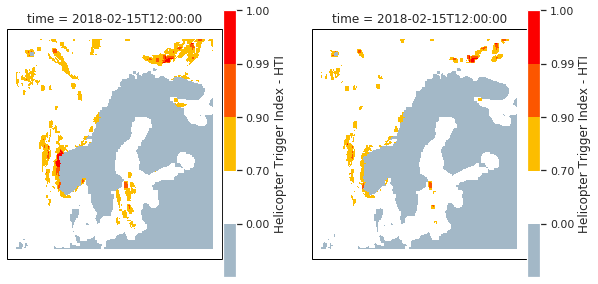

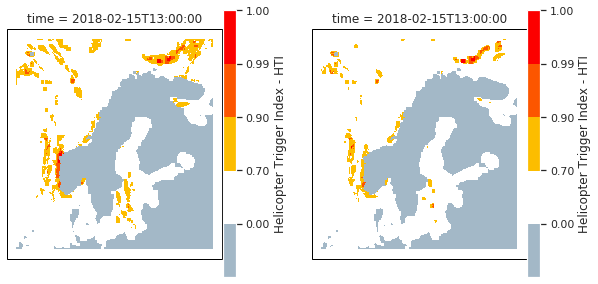

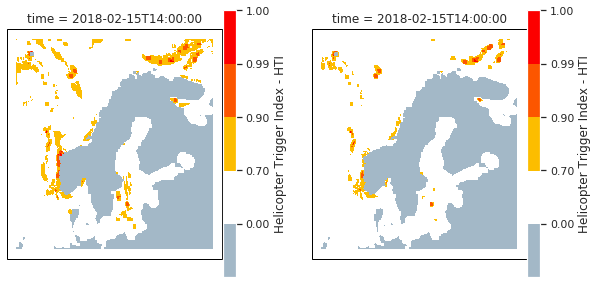

In [102]:
folder = "/home/johannestl/Desktop/Masteroppgaven/Master/source_disk/MEPS/forecasted_HTI_MEPS/" 

MEPS_season = []
for ds in [cases]:
    for i, row in ds.iterrows():
        year = int(str(row[0])[:4])
        if year < 2017:
            continue
        MEPS_season.append(row)
for i, row in enumerate(MEPS_season):
    xarray  = xr.open_dataset(folder+day).isel(ensemble_member=0,height0=0)
    time = xarray.time[0].values.astype('datetime64[M]').astype(int)% 12 +1
    geo_pl, geo_sf, airtemp_pl,  upward_pl, lowcloud, prec = fetchfields(xarray)
    
    prec0 = prec.isel(time = range(1,7))
    prec = (prec- prec.shift({"time":1},fill_value=0)).isel(time = range(1,7))
    prec = prec.where(prec >0,0)
    air_temp = get_height_value_from_pl(geo_pl,airtemp_pl-273.15).isel(time=range(1,7))
    W_ = get_height_value_from_pl(geo_pl,upward_pl).isel(time=range(1,7))
    lowcloud = lowcloud.isel(time=range(1,7))
    
    
    Nbh = 7
    W = np.zeros_like(W_)
    cl = np.zeros_like(lowcloud)
    pc = np.zeros_like(prec0)
    pc_fix = np.zeros_like(prec)
    for time in range(len(W_["time"])):
        W[time] = neighbourhood_max(W_.isel(time=time).values,Nbh)
        cl[time] = neighbourhood_max(lowcloud.isel(time=time).values,Nbh)
        cl[time] -= neighbourhood_min(lowcloud.isel(time=time).values,Nbh)
        pc[time] = neighbourhood_max(prec0.isel(time=time).values,Nbh)
        pc_fix[time] = neighbourhood_max(prec.isel(time=time).values,Nbh)
    
    Wpart = np.mean(mask(wfunc(W)),axis=0)
    Cpart = np.mean(mask(wfunc(cl)),axis=0)
    if np.isnan(np.sum(Wpart)) or np.isnan(np.sum(Cpart)):
        print(day)
        continue

In [27]:
folder = "/home/johannestl/Desktop/Masteroppgaven/Master/source_disk/MEPS/forecasted_HTI_MEPS/" 
N = 0

for ds in [cases]:
    for i, row in ds.iterrows():
        year = int(str(row[0])[:4])
        if year < 2017:
            continue
        height = row[-3]
        if not height > 0:
            continue
        lat,lon = row[4:6]
        if lat < 0:
            # nan
            continue
        term = [0,6,12,18][row[1]//6]
        try:
            HTI = xr.open_dataset(folder+"HTI_%iT%2.2iZ.nc"%(row[0],term))
            HTI_fixed = (xr.open_dataset(folder+"HTI_%iT%2.2iZ_fixed.nc"%(row[0],term)))
            HTI_fixed = HTI_fixed.where(HTI_fixed > 0, 0)
        except:
            continue
            
        point = sgeom.Point(lon,lat)
        Point = projection.project_geometry(point)
        fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection': projection},figsize = (10,7))
        T = HTI["helicopter_triggered_index"].isel(time=row[1]%6).time.values
        
        try:
            plot_HTI(HTI_fixed["helicopter_triggered_index"].sel(time=T),ax2)
        except:
            if term == 0:
                continue
            HTI_fixed = (xr.open_dataset(folder+"HTI_%iT%2.2iZ_fixed.nc"%(row[0],term-6)))
            HTI_fixed = HTI_fixed.where(HTI_fixed > 0, 0)
            plot_HTI(HTI_fixed["helicopter_triggered_index"].sel(time=T),ax2)
            HTI = xr.open_dataset(folder+"HTI_%iT%2.2iZ.nc"%(row[0],term-6))

        plot_HTI(HTI["helicopter_triggered_index"].sel(time=T),ax1)
            
        point_ds = HTI.sel(x=Point.x, y=Point.y,method="nearest")
        
        HTIv = point_ds["helicopter_triggered_index"].sel(time=T).values
        HTIf = HTI_fixed["helicopter_triggered_index"].sel(x=Point.x, y=Point.y,method="nearest").sel(time=T).values

        ax1.set_title("Before fix %.2f"%HTIv)
        ax2.set_title("After fix %.2f"%HTIf)
        fig.suptitle("%s at %.2f feet height"%({"H":"Helicopter","FW":"Fixed Wing"}[row[-1]],row[-3]),va="bottom",y=0.82)
        point_ds.plot.scatter("x","y",color='k',ax=ax1,alpha=0.5)
        point_ds.plot.scatter("x","y",color='k',ax=ax2,alpha=0.5)
        fig.savefig(outsource+"%2.2i.png"%N, bbox_inches = 'tight', pad_inches = 0.01)
        N+=1
        plt.close("all")


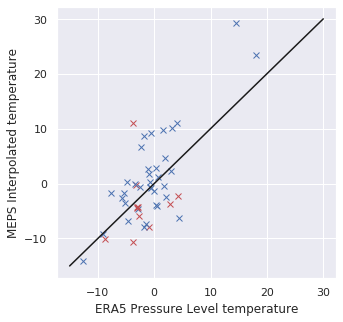

In [6]:
def get_height_value_from_pl(geopotential_pl,variable_pl,height=750):
    # Assume 925 to 850 band always has interesting heights. May need changing later
    # Also Assume 9.81 is correct gravitational constant ( should be to 1%)
    z2,z1 = geopotential_pl.sel(pressure=850)/9.81 , geopotential_pl.sel(pressure=925)/9.81
    v2,v1 = variable_pl.sel(pressure=850) , variable_pl.sel(pressure=925)
    variableperheight = (v2-v1)/(z2-z1)
    result = v1 + variableperheight*(height - z1)
    return result

def estimate_pl(geopotential_pl,case_height):
    mean_height_pl = f_2_m(geopotential_pl.mean(axis=1).mean(axis=1)/9.81,1)
    dist = mean_height_pl - case_height
    return int(np.argmin(abs(dist)).values)

def get_height_value_from_pl_era5(geopotential_pl,variable_pl,height=750,pmax=0,pmin=1):
    # pmax is index of levellist [975,950,925,900,875,850,825,800], if longer, geopotential is longer.
    # Also Assume 9.81 is correct gravitational constant ( should be to 1%)
    z2,z1 = geopotential_pl.isel(level=pmin)/9.81 , geopotential_pl.isel(level=pmax)/9.81
    v2,v1 = variable_pl.isel(level=pmin) , variable_pl.isel(level=pmax)
    variableperheight = (v2-v1)/(z2-z1)
    result = v1 + variableperheight*(height - z1)
    return result
def fetchfields(xarray):
    # Fetch fields used for operational HTI - post proccessing
    geo_pl = xarray["geopotential_pl"]
    geo_sf = xarray["surface_geopotential"]
    airtemp_pl = xarray["air_temperature_pl"]

    return  geo_pl, geo_sf, airtemp_pl

sub_folder = "source_disk/MEPS/subset_variables/"
ext_folder = "source_disk/MEPS/extracted_variables/"
era_folder = "source_disk/era5/specific_patterns/"
plt.figure(figsize=(5,5))
for ds in [cases]:
    for i, row in ds.iterrows():
        year = int(str(row[0])[:4])
        if year < 2017:
            continue
        height = row[-3]
        if not height > 0:
            continue
        lat,lon = row[4:6]
        if lat < 0:
            # nan
            continue
        term = [0,6,12,18][row[1]//6]
        try:
            MEPS = xr.open_dataset(sub_folder+"subset_%iT%2.2iZ.nc"%(row[0],term))
        except:
            try:
                MEPS = xr.open_dataset(ext_folder+"extracted_%iT%2.2iZ.nc"%(row[0],term))

            except:
                continue
        ERA5 = xr.open_dataset(era_folder+"%i%2.2i.nc"%(row[0],row[1])).isel(time=0)
        MEPS = MEPS.isel(ensemble_member=0,height0=0)
        T = MEPS.isel(time=row[1]%6).time.values
        MEPS = MEPS.sel(time=T)
        point = sgeom.Point(lat,lon)
        Point = projection.project_geometry(point)
        MEPS = MEPS.sel(x=Point.x,y=Point.y,method="nearest")
        try:
            geo_pl, geo_sf, airtemp_pl = fetchfields(MEPS)
        except:
            continue
        TMeps = get_height_value_from_pl(geo_pl-geo_sf,airtemp_pl,height=f_2_m(height))-273.15
        
        ind = estimate_pl(ERA5["z"],height)
        T750 = get_height_value_from_pl_era5(ERA5["z"],ERA5["t"],height=f_2_m(height),pmax=ind,pmin=ind+1)-273.15 
        T750 = T750.sel(latitude=lat,longitude=lon,method = "nearest")
        if row[-1] == "H":
            plt.plot(T750,TMeps,"rx")
        else:
            plt.plot(T750,TMeps,"bx")
plt.plot(np.linspace(-15,30,2),np.linspace(-15,30,2),"k")
plt.xlabel("ERA5 Pressure Level temperature")
plt.ylabel("MEPS Interpolated temperature")
plt.savefig(outsource+"T750MEPSera5diff.pdf",bbox_inches = 'tight', pad_inches = 0.01)

In [68]:
folder = "source_disk/MEPS/extracted_variables/"
htiseason2019 = []
for file in sorted(os.listdir(folder))[1:]:
    year = int(file[10:14])
    month = int(file[14:16])
    if year == 2019:
        if month < 5 or month > 9:
            htiseason2019.append(file)


In [69]:
print(htiseason)

['extracted_20181001T00Z.nc', 'extracted_20181001T06Z.nc', 'extracted_20181001T12Z.nc', 'extracted_20181001T18Z.nc', 'extracted_20181002T00Z.nc', 'extracted_20181002T06Z.nc', 'extracted_20181002T12Z.nc', 'extracted_20181002T18Z.nc', 'extracted_20181003T00Z.nc', 'extracted_20181003T06Z.nc', 'extracted_20181003T12Z.nc', 'extracted_20181003T18Z.nc', 'extracted_20181004T00Z.nc', 'extracted_20181004T06Z.nc', 'extracted_20181004T12Z.nc', 'extracted_20181004T18Z.nc', 'extracted_20181005T00Z.nc', 'extracted_20181005T06Z.nc', 'extracted_20181005T12Z.nc', 'extracted_20181005T18Z.nc', 'extracted_20181006T00Z.nc', 'extracted_20181006T06Z.nc', 'extracted_20181006T12Z.nc', 'extracted_20181006T18Z.nc', 'extracted_20181007T00Z.nc', 'extracted_20181007T06Z.nc', 'extracted_20181007T12Z.nc', 'extracted_20181007T18Z.nc', 'extracted_20181008T00Z.nc', 'extracted_20181008T06Z.nc', 'extracted_20181008T12Z.nc', 'extracted_20181008T18Z.nc', 'extracted_20181009T00Z.nc', 'extracted_20181009T06Z.nc', 'extracted_20